In [1]:
import os
import requests
import tarfile
import time

from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import torchvision.models as models
import torch.nn as nn
import torch
from torch import optim
from torchsummary import summary

import PIL.Image
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from copy import deepcopy
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import timm
import uuid
import pickle

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


### Dataloading

In [2]:
transform = transforms.Compose([transforms.Resize((380,380)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=5, scale=(0.8,1.2)), 
                              #   transforms.RandomGrayscale(p=0.1), 
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

val_transform = transforms.Compose([transforms.Resize((380,380)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                        ])

In [3]:
class TransformedDataset(Dataset):
    def __init__(self, dataset: Dataset, transform: transforms.Compose):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img, label = self.dataset[index]

        if self.transform:
            img = self.transform(img)
        
        return img, label

def stratified_split(dataset, val_split=0.):
    targets = np.array(dataset.targets)

    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        test_size=val_split,
        stratify=targets
    )

    # train_dataset = Subset(dataset, indices=train_indices)
    # val_dataset = Subset(dataset, indices=val_indices)
    # return train_dataset, val_dataset

    return train_indices, val_indices

In [4]:
# Load the dataset separately for training and validation
dataset = datasets.ImageFolder(root = "./final_data")

# train_indices, val_indices = stratified_split(dataset, val_split=0.2)

# Loading the indices from the saved pickle file to ensure the same split is used across different models
with open('train_indices.pkl', 'rb') as f:
    train_indices = pickle.load(f)

with open('val_indices.pkl', 'rb') as f:
    val_indices = pickle.load(f)

# Split the dataset into training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

transformed_train = TransformedDataset(train_dataset, transform)
transformed_val = TransformedDataset(val_dataset, val_transform)

In [5]:
# train_loader = DataLoader(transformed_train, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=2)
train_loader = DataLoader(transformed_train, batch_size=32, shuffle=True)
val_loader = DataLoader(transformed_val, batch_size=32, shuffle=False)

In [6]:
# # Store all datapoints from transformed_train
# train_images = []
# train_labels = []
# for i in range(len(transformed_train)):
#     img, label = transformed_train[i]
#     train_images.append(img)
#     train_labels.append(label)

# # Store all datapoints from transformed_val
# val_images = []
# val_labels = []
# for i in range(len(transformed_val)):
#     img, label = transformed_val[i]
#     val_images.append(img)
#     val_labels.append(label)

# train_full = (torch.stack(train_images).to(device), torch.tensor(train_labels).to(device))
# val_full = (torch.stack(val_images).to(device), torch.tensor(val_labels).to(device))

### Model Instantiation

In [7]:
model = models.efficientnet_v2_l(weights="DEFAULT")

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(1280, len(dataset.classes))
model = model.to(device)

model_paradigm = "efficientnet_v2_l"

### Training Setup - Model Evaluation

In [8]:
def top_k_accuracy(output, target, k=5):
    batch_size = target.size(0)
    _, pred = output.topk(k, 1, True, True)  # Get top-k predictions
    pred = pred.t()  # Transpose predictions for comparison
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))  # Compare predictions with target
    correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)  # Calculate correct top-k
    return correct_k.mul_(1.0 / batch_size).detach()  # Calculate top-k accuracy

def evaluate(model, loss_fn, data_loader):
    model.eval()

    loss = 0
    correct = 0
    total = 0
    top_1_accuracy = 0
    top_5_accuracy = 0

    progress_bar = tqdm(data_loader, desc = "Validating")

    with torch.no_grad():
        for batchX, batchY in progress_bar:
            batchX, batchY = batchX.to(device), batchY.to(device)

            output = model(batchX)
            predicted_labels = torch.argmax(output, dim = 1)

            loss += loss_fn(output, batchY).detach() * batchX.size(0)
            correct += (predicted_labels == batchY.type(torch.long)).sum().detach()
            total += batchX.size(0)
            top_1_accuracy += top_k_accuracy(output, batchY, k=1) * batchX.size(0)
            top_5_accuracy += top_k_accuracy(output, batchY, k=5) * batchX.size(0)
    
    return loss.item() / total, correct.item() / total, top_1_accuracy.item() / total, top_5_accuracy.item() / total

def evaluate_all(model, loss_fn, allX, allY):
    model.eval()

    loss = 0
    correct = 0
    top_1_accuracy = 0
    top_5_accuracy = 0

    allX, allY = allX.to(device), allY.to(device)

    with torch.no_grad():
        output = model(allX)
        predicted_labels = torch.argmax(output, dim = 1)

        loss += loss_fn(output, allY.type(torch.long)).detach()
        correct += (predicted_labels == allY.type(torch.long)).sum().detach()
        top_1_accuracy += top_k_accuracy(output, allY, k=1)
        top_5_accuracy += top_k_accuracy(output, allY, k=5)
    
    return loss.item(), correct.item() / allX.size(0), top_1_accuracy.item(), top_5_accuracy.item()

In [9]:
def plot_model_history(his):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ln1 = ax.plot(his['train_loss'], 'b--',label='loss')
    ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
    ax.set_ylabel('loss', color='blue')
    ax.tick_params(axis='y', colors="blue")

    ax2 = ax.twinx()
    ln3 = ax2.plot(his['train_acc'], 'r--',label='accuracy')
    ln4 = ax2.plot(his['val_acc'], 'r-',label='val_accuracy')
    ax2.set_ylabel('accuracy', color='red')
    ax2.tick_params(axis='y', colors="red")

    lns = ln1 + ln2 + ln3 + ln4
    labels = [l.get_label() for l in lns]
    ax.legend(lns, labels, loc=7)
    plt.grid(True)
    plt.show()

In [10]:
optim_dict = {"Adam":optim.Adam, "Adadelta":optim.Adadelta, "Adagrad":optim.Adagrad,
              "Adamax":optim.Adamax, "AdamW": optim.AdamW, "ASGD":optim.ASGD,
              "NAdam":optim.NAdam, "RMSprop":optim.RMSprop, "RAdam":optim.RAdam,
              "Rprop": optim.Rprop, "SGD":optim.SGD}


# Loss and optimiser
# NOTE: Please note that different learning_rates were used for different models at different stages of experimentation.
# learning_rate = 0.0001
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimiser = optim_dict["Adam"](model.parameters(), lr=learning_rate)
num_epochs = 200

In [11]:
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

In [12]:
best_val_loss = float('inf')
best_val_acc = -1

# Early stopping - based on validation loss
patience_counter = 0
patience = 20

for epoch in range(num_epochs):
    model.train()

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')

    running_loss = 0.0
    running_correct = 0
    total = 0

    for X, y in progress_bar:
        X, y = X.to(device), y.to(device)

        outputs = model(X)

        loss = loss_fn(outputs, y)

        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        running_loss += loss.detach() * X.size(0)
        running_correct += (torch.argmax(outputs, dim = 1) == y.type(torch.long)).sum().detach()
        total += X.size(0)
    
    running_loss = running_loss.item()
    running_correct = running_correct.item()

    # Evaluate the model after training is done instead of using running averages
    # train_loss, train_acc = evaluate_all(model, loss_fn, train_full[0], train_full[1])
    train_loss, train_acc = running_loss / total, running_correct / total
    # val_loss, val_acc = evaluate_all(model, loss_fn, val_full[0], val_full[1])
    val_loss, val_acc, top_1, top_5 = evaluate(model, loss_fn, val_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model_{model_paradigm}.pth')

    # Patience is counted based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f'best_model_acc_{model_paradigm}.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    # torch.save(model.state_dict(), f'model_{model_paradigm}_epoch_{epoch+1}.pth')
    
    tqdm.write(f'Loss: {train_loss:.4f} - Accuracy: {train_acc*100:.4f}% - Val Loss: {val_loss:.4f} - Val Accuracy: {val_acc*100:.4f}% - Top 1 Accuracy: {top_1} - Top 5 Accuracy: {top_5}')

    if patience_counter == patience:
        print(f'Early stopping: patience limit reached after epoch {epoch + 1}')
        break

Epoch 1:  41%|████      | 59/144 [00:20<00:28,  3.03it/s]c:\Users\Raven\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating: 100%|██████████| 36/36 [00:07<00:00,  4.67it/s]


Loss: 1.9440 - Accuracy: 25.4079% - Val Loss: 1.7232 - Val Accuracy: 50.0870% - Top 1 Accuracy: 0.5008695652173913 - Top 5 Accuracy: 0.9443478260869566


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.30it/s]


Loss: 1.6204 - Accuracy: 48.2924% - Val Loss: 1.4722 - Val Accuracy: 67.9130% - Top 1 Accuracy: 0.6791304347826087 - Top 5 Accuracy: 0.9791304347826087


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.46it/s]


Loss: 1.4036 - Accuracy: 58.8645% - Val Loss: 1.2924 - Val Accuracy: 73.2174% - Top 1 Accuracy: 0.7321739130434782 - Top 5 Accuracy: 0.9852173913043478


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.29it/s]


Loss: 1.2403 - Accuracy: 65.7168% - Val Loss: 1.1603 - Val Accuracy: 76.5217% - Top 1 Accuracy: 0.7652173913043478 - Top 5 Accuracy: 0.9860869565217392


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.29it/s]


Loss: 1.1296 - Accuracy: 67.2178% - Val Loss: 1.0494 - Val Accuracy: 77.6522% - Top 1 Accuracy: 0.7765217391304348 - Top 5 Accuracy: 0.9886956521739131


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.35it/s]


Loss: 1.0530 - Accuracy: 70.2632% - Val Loss: 0.9830 - Val Accuracy: 79.6522% - Top 1 Accuracy: 0.7965217391304348 - Top 5 Accuracy: 0.9895652173913043


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.32it/s]


Loss: 0.9994 - Accuracy: 71.7207% - Val Loss: 0.9208 - Val Accuracy: 80.1739% - Top 1 Accuracy: 0.8017391304347826 - Top 5 Accuracy: 0.9895652173913043


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.33it/s]


Loss: 0.9429 - Accuracy: 72.5473% - Val Loss: 0.8609 - Val Accuracy: 80.8696% - Top 1 Accuracy: 0.808695652173913 - Top 5 Accuracy: 0.9921739130434782


Validating: 100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Loss: 0.8872 - Accuracy: 74.3963% - Val Loss: 0.8193 - Val Accuracy: 81.3043% - Top 1 Accuracy: 0.8130434782608695 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.01it/s]


Loss: 0.8614 - Accuracy: 74.6356% - Val Loss: 0.7761 - Val Accuracy: 82.7826% - Top 1 Accuracy: 0.8278260869565217 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:05<00:00,  6.95it/s]


Loss: 0.8369 - Accuracy: 75.4623% - Val Loss: 0.7645 - Val Accuracy: 82.1739% - Top 1 Accuracy: 0.8217391304347826 - Top 5 Accuracy: 0.9921739130434782


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.03it/s]


Loss: 0.8058 - Accuracy: 75.5058% - Val Loss: 0.7321 - Val Accuracy: 82.9565% - Top 1 Accuracy: 0.8295652173913044 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.20it/s]


Loss: 0.7913 - Accuracy: 75.8321% - Val Loss: 0.6918 - Val Accuracy: 83.7391% - Top 1 Accuracy: 0.837391304347826 - Top 5 Accuracy: 0.9939130434782608


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.07it/s]


Loss: 0.7640 - Accuracy: 77.2460% - Val Loss: 0.6896 - Val Accuracy: 83.4783% - Top 1 Accuracy: 0.8347826086956521 - Top 5 Accuracy: 0.9921739130434782


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.11it/s]


Loss: 0.7518 - Accuracy: 77.4853% - Val Loss: 0.6827 - Val Accuracy: 83.3043% - Top 1 Accuracy: 0.8330434782608696 - Top 5 Accuracy: 0.9921739130434782


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.11it/s]


Loss: 0.7544 - Accuracy: 76.1801% - Val Loss: 0.6431 - Val Accuracy: 83.9130% - Top 1 Accuracy: 0.8391304347826087 - Top 5 Accuracy: 0.991304347826087


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.07it/s]


Loss: 0.7399 - Accuracy: 76.4629% - Val Loss: 0.6556 - Val Accuracy: 84.1739% - Top 1 Accuracy: 0.8417391304347827 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.19it/s]


Loss: 0.7097 - Accuracy: 77.6376% - Val Loss: 0.6323 - Val Accuracy: 83.7391% - Top 1 Accuracy: 0.837391304347826 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.09it/s]


Loss: 0.7082 - Accuracy: 77.9204% - Val Loss: 0.6236 - Val Accuracy: 83.8261% - Top 1 Accuracy: 0.8382608695652174 - Top 5 Accuracy: 0.9939130434782608


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.13it/s]


Loss: 0.6803 - Accuracy: 78.7470% - Val Loss: 0.6219 - Val Accuracy: 84.0000% - Top 1 Accuracy: 0.84 - Top 5 Accuracy: 0.9939130434782608


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.16it/s]


Loss: 0.6751 - Accuracy: 79.0080% - Val Loss: 0.6000 - Val Accuracy: 84.3478% - Top 1 Accuracy: 0.8434782608695652 - Top 5 Accuracy: 0.9939130434782608


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.12it/s]


Loss: 0.6655 - Accuracy: 78.3772% - Val Loss: 0.5914 - Val Accuracy: 84.0870% - Top 1 Accuracy: 0.8408695652173913 - Top 5 Accuracy: 0.9921739130434782


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.36it/s]


Loss: 0.6655 - Accuracy: 79.2473% - Val Loss: 0.5723 - Val Accuracy: 84.6957% - Top 1 Accuracy: 0.8469565217391304 - Top 5 Accuracy: 0.9921739130434782


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.15it/s]


Loss: 0.6672 - Accuracy: 78.3990% - Val Loss: 0.5717 - Val Accuracy: 84.6957% - Top 1 Accuracy: 0.8469565217391304 - Top 5 Accuracy: 0.9939130434782608


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.09it/s]


Loss: 0.6587 - Accuracy: 78.7688% - Val Loss: 0.5556 - Val Accuracy: 84.6957% - Top 1 Accuracy: 0.8469565217391304 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.06it/s]


Loss: 0.6461 - Accuracy: 78.8993% - Val Loss: 0.5595 - Val Accuracy: 84.7826% - Top 1 Accuracy: 0.8478260869565217 - Top 5 Accuracy: 0.9939130434782608


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.14it/s]


Loss: 0.6464 - Accuracy: 78.4860% - Val Loss: 0.5556 - Val Accuracy: 84.4348% - Top 1 Accuracy: 0.8443478260869566 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.10it/s]


Loss: 0.6523 - Accuracy: 78.8775% - Val Loss: 0.5508 - Val Accuracy: 84.8696% - Top 1 Accuracy: 0.8486956521739131 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.12it/s]


Loss: 0.6297 - Accuracy: 79.5301% - Val Loss: 0.5341 - Val Accuracy: 85.4783% - Top 1 Accuracy: 0.8547826086956521 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.25it/s]


Loss: 0.6120 - Accuracy: 80.3568% - Val Loss: 0.5281 - Val Accuracy: 85.5652% - Top 1 Accuracy: 0.8556521739130435 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.32it/s]


Loss: 0.6152 - Accuracy: 79.6171% - Val Loss: 0.5144 - Val Accuracy: 85.5652% - Top 1 Accuracy: 0.8556521739130435 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.29it/s]


Loss: 0.6332 - Accuracy: 79.3126% - Val Loss: 0.5199 - Val Accuracy: 85.5652% - Top 1 Accuracy: 0.8556521739130435 - Top 5 Accuracy: 0.9930434782608696


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.14it/s]


Loss: 0.6207 - Accuracy: 80.2045% - Val Loss: 0.5051 - Val Accuracy: 85.4783% - Top 1 Accuracy: 0.8547826086956521 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.07it/s]


Loss: 0.6169 - Accuracy: 79.3126% - Val Loss: 0.5121 - Val Accuracy: 84.8696% - Top 1 Accuracy: 0.8486956521739131 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.24it/s]


Loss: 0.6005 - Accuracy: 79.8782% - Val Loss: 0.5026 - Val Accuracy: 85.8261% - Top 1 Accuracy: 0.8582608695652174 - Top 5 Accuracy: 0.9939130434782608


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.32it/s]


Loss: 0.6114 - Accuracy: 80.2697% - Val Loss: 0.4995 - Val Accuracy: 85.5652% - Top 1 Accuracy: 0.8556521739130435 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.16it/s]


Loss: 0.6061 - Accuracy: 79.3126% - Val Loss: 0.5037 - Val Accuracy: 85.6522% - Top 1 Accuracy: 0.8565217391304348 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.20it/s]


Loss: 0.6014 - Accuracy: 80.0522% - Val Loss: 0.4880 - Val Accuracy: 85.6522% - Top 1 Accuracy: 0.8565217391304348 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.33it/s]


Loss: 0.5887 - Accuracy: 80.5960% - Val Loss: 0.4964 - Val Accuracy: 85.3043% - Top 1 Accuracy: 0.8530434782608696 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.16it/s]


Loss: 0.5802 - Accuracy: 80.7918% - Val Loss: 0.4972 - Val Accuracy: 85.1304% - Top 1 Accuracy: 0.851304347826087 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.35it/s]


Loss: 0.5840 - Accuracy: 80.7701% - Val Loss: 0.4811 - Val Accuracy: 85.8261% - Top 1 Accuracy: 0.8582608695652174 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.31it/s]


Loss: 0.5916 - Accuracy: 80.9006% - Val Loss: 0.4757 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.40it/s]


Loss: 0.5863 - Accuracy: 80.7483% - Val Loss: 0.4751 - Val Accuracy: 85.8261% - Top 1 Accuracy: 0.8582608695652174 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.27it/s]


Loss: 0.5669 - Accuracy: 80.4655% - Val Loss: 0.4812 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.39it/s]


Loss: 0.5812 - Accuracy: 80.7483% - Val Loss: 0.4692 - Val Accuracy: 85.7391% - Top 1 Accuracy: 0.8573913043478261 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.23it/s]


Loss: 0.5768 - Accuracy: 80.6178% - Val Loss: 0.4603 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.36it/s]


Loss: 0.5733 - Accuracy: 80.5960% - Val Loss: 0.4649 - Val Accuracy: 86.0870% - Top 1 Accuracy: 0.8608695652173913 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.32it/s]


Loss: 0.5605 - Accuracy: 81.2269% - Val Loss: 0.4726 - Val Accuracy: 86.0870% - Top 1 Accuracy: 0.8608695652173913 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.27it/s]


Loss: 0.5681 - Accuracy: 81.0746% - Val Loss: 0.4614 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  6.95it/s]


Loss: 0.5597 - Accuracy: 80.9876% - Val Loss: 0.4583 - Val Accuracy: 85.8261% - Top 1 Accuracy: 0.8582608695652174 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.12it/s]


Loss: 0.5557 - Accuracy: 81.3139% - Val Loss: 0.4502 - Val Accuracy: 85.7391% - Top 1 Accuracy: 0.8573913043478261 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.17it/s]


Loss: 0.5565 - Accuracy: 81.1181% - Val Loss: 0.4664 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.02it/s]


Loss: 0.5571 - Accuracy: 81.0964% - Val Loss: 0.4565 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.10it/s]


Loss: 0.5660 - Accuracy: 80.9006% - Val Loss: 0.4600 - Val Accuracy: 86.1739% - Top 1 Accuracy: 0.8617391304347826 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.16it/s]


Loss: 0.5707 - Accuracy: 80.5960% - Val Loss: 0.4575 - Val Accuracy: 85.9130% - Top 1 Accuracy: 0.8591304347826086 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.08it/s]


Loss: 0.5622 - Accuracy: 80.6613% - Val Loss: 0.4499 - Val Accuracy: 86.6957% - Top 1 Accuracy: 0.8669565217391304 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.13it/s]


Loss: 0.5568 - Accuracy: 81.3139% - Val Loss: 0.4497 - Val Accuracy: 85.9130% - Top 1 Accuracy: 0.8591304347826086 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.05it/s]


Loss: 0.5607 - Accuracy: 80.3785% - Val Loss: 0.4482 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.02it/s]


Loss: 0.5568 - Accuracy: 81.2704% - Val Loss: 0.4502 - Val Accuracy: 85.9130% - Top 1 Accuracy: 0.8591304347826086 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.14it/s]


Loss: 0.5593 - Accuracy: 80.8788% - Val Loss: 0.4453 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.06it/s]


Loss: 0.5539 - Accuracy: 81.0529% - Val Loss: 0.4387 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.12it/s]


Loss: 0.5512 - Accuracy: 81.2051% - Val Loss: 0.4465 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.01it/s]


Loss: 0.5398 - Accuracy: 81.2704% - Val Loss: 0.4399 - Val Accuracy: 85.9130% - Top 1 Accuracy: 0.8591304347826086 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.10it/s]


Loss: 0.5552 - Accuracy: 81.1181% - Val Loss: 0.4513 - Val Accuracy: 85.8261% - Top 1 Accuracy: 0.8582608695652174 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.04it/s]


Loss: 0.5463 - Accuracy: 81.2704% - Val Loss: 0.4497 - Val Accuracy: 85.8261% - Top 1 Accuracy: 0.8582608695652174 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.09it/s]


Loss: 0.5389 - Accuracy: 81.8577% - Val Loss: 0.4379 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.09it/s]


Loss: 0.5615 - Accuracy: 81.3139% - Val Loss: 0.4344 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.05it/s]


Loss: 0.5467 - Accuracy: 80.9876% - Val Loss: 0.4340 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.11it/s]


Loss: 0.5358 - Accuracy: 82.3798% - Val Loss: 0.4446 - Val Accuracy: 85.7391% - Top 1 Accuracy: 0.8573913043478261 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.06it/s]


Loss: 0.5434 - Accuracy: 82.0535% - Val Loss: 0.4385 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.07it/s]


Loss: 0.5520 - Accuracy: 81.5532% - Val Loss: 0.4347 - Val Accuracy: 86.7826% - Top 1 Accuracy: 0.8678260869565217 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.09it/s]


Loss: 0.5512 - Accuracy: 81.2921% - Val Loss: 0.4359 - Val Accuracy: 85.4783% - Top 1 Accuracy: 0.8547826086956521 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.14it/s]


Loss: 0.5479 - Accuracy: 81.7707% - Val Loss: 0.4412 - Val Accuracy: 85.5652% - Top 1 Accuracy: 0.8556521739130435 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.08it/s]


Loss: 0.5552 - Accuracy: 81.2051% - Val Loss: 0.4366 - Val Accuracy: 85.9130% - Top 1 Accuracy: 0.8591304347826086 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:05<00:00,  7.00it/s]


Loss: 0.5537 - Accuracy: 81.3574% - Val Loss: 0.4317 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.21it/s]


Loss: 0.5479 - Accuracy: 81.3574% - Val Loss: 0.4308 - Val Accuracy: 86.8696% - Top 1 Accuracy: 0.8686956521739131 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.40it/s]


Loss: 0.5577 - Accuracy: 80.9658% - Val Loss: 0.4287 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.22it/s]


Loss: 0.5450 - Accuracy: 81.4879% - Val Loss: 0.4326 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.41it/s]


Loss: 0.5325 - Accuracy: 82.3581% - Val Loss: 0.4233 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.34it/s]


Loss: 0.5299 - Accuracy: 82.3363% - Val Loss: 0.4176 - Val Accuracy: 86.8696% - Top 1 Accuracy: 0.8686956521739131 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.40it/s]


Loss: 0.5437 - Accuracy: 81.5749% - Val Loss: 0.4250 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.29it/s]


Loss: 0.5401 - Accuracy: 81.4009% - Val Loss: 0.4198 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.29it/s]


Loss: 0.5487 - Accuracy: 81.4009% - Val Loss: 0.4277 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.30it/s]


Loss: 0.5317 - Accuracy: 82.4668% - Val Loss: 0.4266 - Val Accuracy: 86.1739% - Top 1 Accuracy: 0.8617391304347826 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.37it/s]


Loss: 0.5404 - Accuracy: 80.7918% - Val Loss: 0.4203 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.33it/s]


Loss: 0.5303 - Accuracy: 81.3792% - Val Loss: 0.4165 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.39it/s]


Loss: 0.5263 - Accuracy: 82.2058% - Val Loss: 0.4216 - Val Accuracy: 86.6957% - Top 1 Accuracy: 0.8669565217391304 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.35it/s]


Loss: 0.5449 - Accuracy: 81.4662% - Val Loss: 0.4320 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.32it/s]


Loss: 0.5451 - Accuracy: 80.9441% - Val Loss: 0.4174 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5324 - Accuracy: 82.1405% - Val Loss: 0.4294 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.24it/s]


Loss: 0.5351 - Accuracy: 81.7490% - Val Loss: 0.4153 - Val Accuracy: 86.9565% - Top 1 Accuracy: 0.8695652173913043 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.31it/s]


Loss: 0.5289 - Accuracy: 81.8795% - Val Loss: 0.4183 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.31it/s]


Loss: 0.5336 - Accuracy: 81.6402% - Val Loss: 0.4184 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.40it/s]


Loss: 0.5214 - Accuracy: 81.4444% - Val Loss: 0.4249 - Val Accuracy: 85.8261% - Top 1 Accuracy: 0.8582608695652174 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.31it/s]


Loss: 0.5268 - Accuracy: 82.6844% - Val Loss: 0.4177 - Val Accuracy: 86.6957% - Top 1 Accuracy: 0.8669565217391304 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.26it/s]


Loss: 0.5396 - Accuracy: 81.7490% - Val Loss: 0.4275 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.34it/s]


Loss: 0.5406 - Accuracy: 81.1181% - Val Loss: 0.4250 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.42it/s]


Loss: 0.5401 - Accuracy: 80.9223% - Val Loss: 0.4135 - Val Accuracy: 86.7826% - Top 1 Accuracy: 0.8678260869565217 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.49it/s]


Loss: 0.5417 - Accuracy: 80.8353% - Val Loss: 0.4251 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5312 - Accuracy: 82.2928% - Val Loss: 0.4193 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.49it/s]


Loss: 0.5265 - Accuracy: 81.8795% - Val Loss: 0.4279 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5206 - Accuracy: 81.9012% - Val Loss: 0.4164 - Val Accuracy: 86.6957% - Top 1 Accuracy: 0.8669565217391304 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5144 - Accuracy: 82.5973% - Val Loss: 0.4088 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.32it/s]


Loss: 0.5189 - Accuracy: 82.4668% - Val Loss: 0.4163 - Val Accuracy: 86.1739% - Top 1 Accuracy: 0.8617391304347826 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.46it/s]


Loss: 0.5310 - Accuracy: 81.6837% - Val Loss: 0.4239 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.52it/s]


Loss: 0.5258 - Accuracy: 81.6620% - Val Loss: 0.4188 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.42it/s]


Loss: 0.5438 - Accuracy: 81.6620% - Val Loss: 0.4077 - Val Accuracy: 86.0870% - Top 1 Accuracy: 0.8608695652173913 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.48it/s]


Loss: 0.5301 - Accuracy: 81.8795% - Val Loss: 0.4113 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.47it/s]


Loss: 0.5255 - Accuracy: 82.0535% - Val Loss: 0.4075 - Val Accuracy: 87.0435% - Top 1 Accuracy: 0.8704347826086957 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.52it/s]


Loss: 0.5079 - Accuracy: 82.5321% - Val Loss: 0.4105 - Val Accuracy: 86.6957% - Top 1 Accuracy: 0.8669565217391304 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5325 - Accuracy: 82.2058% - Val Loss: 0.4224 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.34it/s]


Loss: 0.5242 - Accuracy: 81.9447% - Val Loss: 0.4087 - Val Accuracy: 86.1739% - Top 1 Accuracy: 0.8617391304347826 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.49it/s]


Loss: 0.5471 - Accuracy: 80.3350% - Val Loss: 0.4223 - Val Accuracy: 85.6522% - Top 1 Accuracy: 0.8565217391304348 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.45it/s]


Loss: 0.5404 - Accuracy: 81.4227% - Val Loss: 0.4070 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.37it/s]


Loss: 0.5373 - Accuracy: 81.4444% - Val Loss: 0.4153 - Val Accuracy: 86.0870% - Top 1 Accuracy: 0.8608695652173913 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.44it/s]


Loss: 0.5405 - Accuracy: 81.5967% - Val Loss: 0.4003 - Val Accuracy: 86.8696% - Top 1 Accuracy: 0.8686956521739131 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.51it/s]


Loss: 0.5240 - Accuracy: 81.0529% - Val Loss: 0.4088 - Val Accuracy: 86.6957% - Top 1 Accuracy: 0.8669565217391304 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.50it/s]


Loss: 0.5283 - Accuracy: 81.5532% - Val Loss: 0.4077 - Val Accuracy: 86.8696% - Top 1 Accuracy: 0.8686956521739131 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.51it/s]


Loss: 0.5376 - Accuracy: 80.7048% - Val Loss: 0.4009 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.47it/s]


Loss: 0.5066 - Accuracy: 82.5538% - Val Loss: 0.4198 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.42it/s]


Loss: 0.5142 - Accuracy: 81.9230% - Val Loss: 0.4022 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.46it/s]


Loss: 0.5229 - Accuracy: 81.9230% - Val Loss: 0.4130 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.42it/s]


Loss: 0.5422 - Accuracy: 81.2269% - Val Loss: 0.4039 - Val Accuracy: 86.6957% - Top 1 Accuracy: 0.8669565217391304 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.40it/s]


Loss: 0.5059 - Accuracy: 82.4016% - Val Loss: 0.3993 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5314 - Accuracy: 81.6837% - Val Loss: 0.4087 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.46it/s]


Loss: 0.5167 - Accuracy: 81.4879% - Val Loss: 0.4021 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.45it/s]


Loss: 0.5245 - Accuracy: 81.9012% - Val Loss: 0.4051 - Val Accuracy: 86.9565% - Top 1 Accuracy: 0.8695652173913043 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.41it/s]


Loss: 0.5253 - Accuracy: 81.3792% - Val Loss: 0.4010 - Val Accuracy: 86.9565% - Top 1 Accuracy: 0.8695652173913043 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.47it/s]

Loss: 0.5215 - Accuracy: 81.5749% - Val Loss: 0.4150 - Val Accuracy: 86.1739% - Top 1 Accuracy: 0.8617391304347826 - Top 5 Accuracy: 0.9965217391304347
Early stopping: patience limit reached after epoch 129


In [13]:
# best_val_loss = float('inf')
# best_val_acc = -1

# Early stopping - based on validation loss
patience_counter = 0
patience = 20

for epoch in range(num_epochs, 2*num_epochs):
    model.train()

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')

    running_loss = 0.0
    running_correct = 0
    total = 0

    for X, y in progress_bar:
        X, y = X.to(device), y.to(device)

        outputs = model(X)

        loss = loss_fn(outputs, y)

        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        running_loss += loss.detach() * X.size(0)
        running_correct += (torch.argmax(outputs, dim = 1) == y.type(torch.long)).sum().detach()
        total += X.size(0)
    
    running_loss = running_loss.item()
    running_correct = running_correct.item()

    # Evaluate the model after training is done instead of using running averages
    # train_loss, train_acc = evaluate_all(model, loss_fn, train_full[0], train_full[1])
    train_loss, train_acc = running_loss / total, running_correct / total
    # val_loss, val_acc = evaluate_all(model, loss_fn, val_full[0], val_full[1])
    val_loss, val_acc, top_1, top_5 = evaluate(model, loss_fn, val_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model_{model_paradigm}.pth')

    # Patience is counted based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f'best_model_acc_{model_paradigm}.pth')
        patience_counter = 0
    else:
        patience_counter += 1

    # torch.save(model.state_dict(), f'model_{model_paradigm}_epoch_{epoch+1}.pth')
    
    tqdm.write(f'Loss: {train_loss:.4f} - Accuracy: {train_acc*100:.4f}% - Val Loss: {val_loss:.4f} - Val Accuracy: {val_acc*100:.4f}% - Top 1 Accuracy: {top_1} - Top 5 Accuracy: {top_5}')

    if patience_counter == patience:
        print(f'Early stopping: patience limit reached after epoch {epoch + 1}')
        break

Validating: 100%|██████████| 36/36 [00:04<00:00,  7.42it/s]


Loss: 0.5372 - Accuracy: 81.4444% - Val Loss: 0.4089 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.39it/s]


Loss: 0.5172 - Accuracy: 81.9665% - Val Loss: 0.4030 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.45it/s]


Loss: 0.5182 - Accuracy: 81.8360% - Val Loss: 0.3970 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.40it/s]


Loss: 0.5306 - Accuracy: 81.5967% - Val Loss: 0.4022 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.57it/s]


Loss: 0.5162 - Accuracy: 82.4233% - Val Loss: 0.4082 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.42it/s]


Loss: 0.5350 - Accuracy: 81.2051% - Val Loss: 0.4002 - Val Accuracy: 87.1304% - Top 1 Accuracy: 0.871304347826087 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.40it/s]


Loss: 0.5203 - Accuracy: 81.2704% - Val Loss: 0.4058 - Val Accuracy: 86.6957% - Top 1 Accuracy: 0.8669565217391304 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.44it/s]


Loss: 0.5131 - Accuracy: 82.1840% - Val Loss: 0.4073 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.48it/s]


Loss: 0.5261 - Accuracy: 81.8360% - Val Loss: 0.4021 - Val Accuracy: 85.9130% - Top 1 Accuracy: 0.8591304347826086 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5286 - Accuracy: 81.1834% - Val Loss: 0.3996 - Val Accuracy: 87.3043% - Top 1 Accuracy: 0.8730434782608696 - Top 5 Accuracy: 0.9973913043478261


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.49it/s]


Loss: 0.5041 - Accuracy: 82.0970% - Val Loss: 0.3946 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5077 - Accuracy: 82.2275% - Val Loss: 0.4122 - Val Accuracy: 85.8261% - Top 1 Accuracy: 0.8582608695652174 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.35it/s]


Loss: 0.5211 - Accuracy: 81.8795% - Val Loss: 0.4074 - Val Accuracy: 86.0870% - Top 1 Accuracy: 0.8608695652173913 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.48it/s]


Loss: 0.5109 - Accuracy: 82.0100% - Val Loss: 0.4142 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.36it/s]


Loss: 0.5242 - Accuracy: 82.0318% - Val Loss: 0.3996 - Val Accuracy: 86.6087% - Top 1 Accuracy: 0.8660869565217392 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Loss: 0.5200 - Accuracy: 81.0529% - Val Loss: 0.4019 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.42it/s]


Loss: 0.5102 - Accuracy: 81.7272% - Val Loss: 0.4022 - Val Accuracy: 86.9565% - Top 1 Accuracy: 0.8695652173913043 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.47it/s]


Loss: 0.5115 - Accuracy: 82.7496% - Val Loss: 0.3994 - Val Accuracy: 86.2609% - Top 1 Accuracy: 0.8626086956521739 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.46it/s]


Loss: 0.5177 - Accuracy: 81.7707% - Val Loss: 0.4000 - Val Accuracy: 86.9565% - Top 1 Accuracy: 0.8695652173913043 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.38it/s]


Loss: 0.5154 - Accuracy: 82.3363% - Val Loss: 0.4031 - Val Accuracy: 86.4348% - Top 1 Accuracy: 0.8643478260869565 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.38it/s]


Loss: 0.5104 - Accuracy: 82.1405% - Val Loss: 0.4005 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.42it/s]


Loss: 0.5081 - Accuracy: 82.4451% - Val Loss: 0.3959 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.37it/s]


Loss: 0.5084 - Accuracy: 82.3363% - Val Loss: 0.4039 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9947826086956522


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.49it/s]


Loss: 0.4964 - Accuracy: 82.3146% - Val Loss: 0.3975 - Val Accuracy: 86.0000% - Top 1 Accuracy: 0.86 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.37it/s]


Loss: 0.5274 - Accuracy: 81.7925% - Val Loss: 0.4139 - Val Accuracy: 86.3478% - Top 1 Accuracy: 0.8634782608695653 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.44it/s]


Loss: 0.5100 - Accuracy: 81.9230% - Val Loss: 0.4016 - Val Accuracy: 86.0870% - Top 1 Accuracy: 0.8608695652173913 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.41it/s]


Loss: 0.5389 - Accuracy: 80.4873% - Val Loss: 0.3972 - Val Accuracy: 86.9565% - Top 1 Accuracy: 0.8695652173913043 - Top 5 Accuracy: 0.9956521739130435


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.49it/s]


Loss: 0.5141 - Accuracy: 82.0100% - Val Loss: 0.4011 - Val Accuracy: 86.5217% - Top 1 Accuracy: 0.8652173913043478 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.29it/s]


Loss: 0.5288 - Accuracy: 81.0529% - Val Loss: 0.3998 - Val Accuracy: 85.2174% - Top 1 Accuracy: 0.8521739130434782 - Top 5 Accuracy: 0.9965217391304347


Validating: 100%|██████████| 36/36 [00:04<00:00,  7.45it/s]


Loss: 0.5004 - Accuracy: 82.4886% - Val Loss: 0.3912 - Val Accuracy: 87.2174% - Top 1 Accuracy: 0.8721739130434782 - Top 5 Accuracy: 0.9965217391304347
Early stopping: patience limit reached after epoch 230


In [14]:
# Load the best model
model.load_state_dict(torch.load(f'best_model_acc_{model_paradigm}.pth'))

C:\Users\Raven\AppData\Local\Temp\ipykernel_17996\2034897919.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_acc_{model_par

<All keys matched successfully>

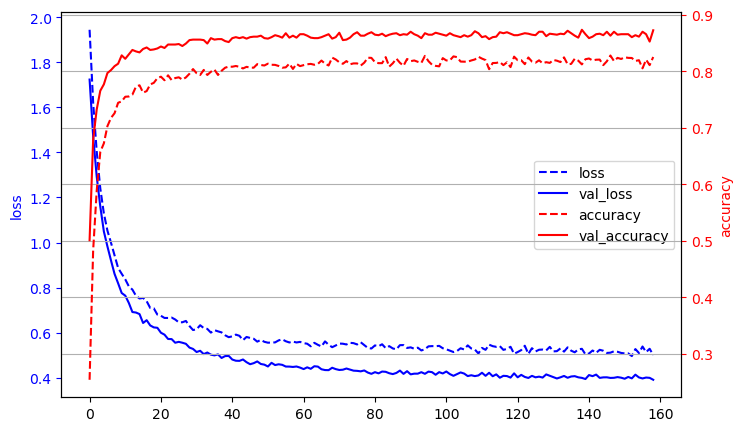

In [15]:
plot_model_history(history)

In [16]:
test_dataset = datasets.ImageFolder(root = "./test_data")
transformed_test = TransformedDataset(test_dataset, val_transform)
test_loader = DataLoader(transformed_test, batch_size=32, shuffle=False)

In [17]:
test_loss, test_acc, top_1, top_5 = evaluate(model, loss_fn, test_loader)
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc*100:.4f}% - Top 1 Accuracy: {top_1} - Top 5 Accuracy: {top_5}')

Validating: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]

Test Loss: 0.6641 - Test Accuracy: 76.2045% - Top 1 Accuracy: 0.7620452310717798 - Top 5 Accuracy: 0.9941002949852508
